Ball by ball overview. Intro about the dataset used (mention missing matches)

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from missingMatches import WICKET_ADDITIONS, RUN_ADDITIONS


In [18]:
# Constants used throughout
COUNTRY_INFO = {
    "Australia" : ("xkcd:canary yellow", "AUS"),
    "Bangladesh" : ("xkcd:pine","BNG"),
    "England": ("xkcd:bright red","ENG"),
    "India": ("xkcd:royal blue", "IND"),
    "Ireland" : ("xkcd:bright green","IRL"),
    "New Zealand": ("xkcd:slate grey", "NZL"),
    "Pakistan" : ("xkcd:emerald", "PAK"),
    "Thailand" : ("xkcd:bright sky blue", "THA"),
    "South Africa" : ("xkcd:yellow/green", "RSA"),
    "Sri Lanka" : ("xkcd:mid blue", "SRI"),
    "West Indies" : ("xkcd:maroon","WIN"), }
DEFAULT_COLOURS = sns.color_palette("bright")
YEARS = ["2014","2016","2018","2020","2023"]
NAME_CHANGES = {
    "NR Sciver": "NR Sciver-Brunt",
    "KH Brunt" : "KH Sciver-Brunt",
}

def namecheck(player):
    """ Replaces a players name with their new one in a df """
    try:
        return NAME_CHANGES[player]
    except KeyError:
        return player 
    

In [19]:
# Read in data, and replace players name with the updated version
raw_data = pd.read_csv("csv files\Ball_by_Ball_Data.csv")
raw_data = raw_data.map(namecheck)
player_data = pd.read_csv("csv files\WCPlayersList.csv")
player_data = player_data.map(namecheck)
for col in player_data.columns:
    player_data.loc[player_data[col].duplicated(),col] = np.NaN

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:4: SyntaxWarning: invalid escape sequence '\W'
C:\Users\annab\AppData\Local\Temp\ipykernel_10024\2738807183.py:2: SyntaxWarning: invalid escape sequence '\B'
  raw_data = pd.read_csv("csv files\Ball_by_Ball_Data.csv")
C:\Users\annab\AppData\Local\Temp\ipykernel_10024\2738807183.py:4: SyntaxWarning: invalid escape sequence '\W'
  player_data = pd.read_csv("csv files\WCPlayersList.csv")


In [20]:
def find_nationality(player):
    """Returns the nationality of a given player (to be used with COUNTRY_INFO)"""
    for k in player_data.columns:
        if player in player_data[k].values:
            return k

First graph intro 

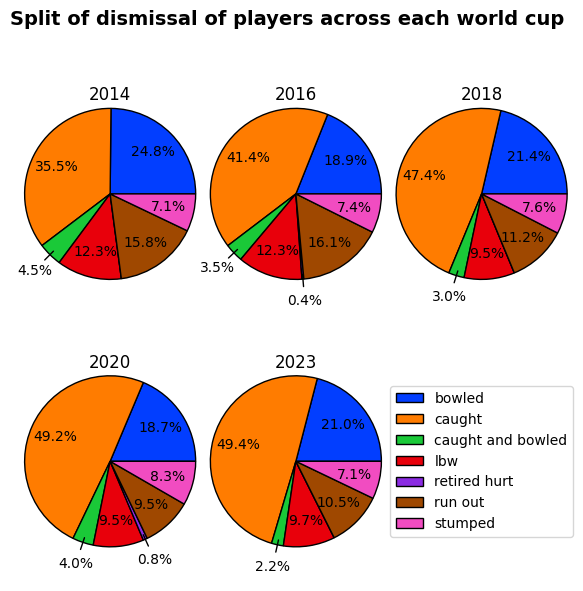

In [21]:
# comparison of methods of players getting out  (pie chart / percentages of each method)

# basic setup of data for this piechart
piechart_data = raw_data[['season','dismissal']].copy()
years = [x for _,x in piechart_data.groupby(piechart_data['season'])]
all_methods = piechart_data['dismissal'].value_counts().sort_index().index.tolist()

# ensures every year has all methods in (so any that are missing are added in with a value of 0) 
percents = []
for idx,year in enumerate(years):
    percs = (year['dismissal'].value_counts().sort_index().tolist())
    labels = (year['dismissal'].value_counts().sort_index().index.tolist())
    missing = set(all_methods) - set(labels)
    comb = list(zip(labels,percs)) + [(x,0) for x in missing]
    all_labs, all_percents = zip(*(sorted(comb)))
    percents.append(all_percents)


# set up figure
fig1, axes1 = plt.subplots(2,3,figsize=(7,7))
axes1 = axes1.ravel()

# makes pie charts for each year (doesn't show percents that are 0)
for idx,ax in enumerate(axes1[:-1]):
    (for_legend,_,texts) =ax.pie(x=percents[idx],colors=DEFAULT_COLOURS,autopct= lambda p : '{:.1f}%'.format(p) if p > 0 else ''
                             ,wedgeprops={'edgecolor' : 'black'},textprops={'fontsize' : 10},radius = 1.25,
                             pctdistance = 0.7)
    ax.set_title(YEARS[idx])
    for text in texts:
        try: 
            if float(text.get_text()[:-1]) < 5:
                (x,y) = text.get_position()
                text.set_position((x*1.8,y*1.8))
                axes1[idx].annotate('', xy=(x*1.3, y*1.3), xytext=(x*1.6, y*1.6),
                                    arrowprops=dict(arrowstyle='-'))
        except ValueError:
            pass


# legends and title set-up
axes1[-1].set_axis_off()
axes1[-1].legend(for_legend,all_methods,loc='center',fontsize=10)
fig1.suptitle("Split of dismissal of players across each world cup",fontsize=14,fontweight='bold')
fig1.subplots_adjust(bottom=0.164,top=0.888,wspace=0.086,hspace=0.117)

first graph comments

second/third/fourth graph intro

In [22]:

def make_bar_chart(ax,series,y_label,col_name):
    """Creates a bar chart from a series"""
    players, values = series.index.to_list(), series[col_name].to_list()
    labels =  [f"{player}\n({int(score)})" for (player,score) in zip(players,values)]
    colours = [COUNTRY_INFO[find_nationality(x)][0] for x in players]

    rects = ax.bar(2*np.arange(len(labels)), values ,1.2,color=colours,edgecolor='black')
    ax.bar_label(rects, labels=labels, padding=3,rotation=10)

    ax.set_ylabel(y_label)
    ax.set_xticks([])
    ax.spines[['right', 'top']].set_visible(False)


In [23]:

# # top run scorers and wicket takers over all WCs 
top_run_wicket_data = raw_data[['season','batter','bowler','runs_off_bat','player_out','dismissal','non_boundary','extras_off_ball']].copy()
top_run_wicket_data['valid wicket'] = ~((top_run_wicket_data['player_out'].isnull()) | (top_run_wicket_data['dismissal'].isin(['run out','retired hurt'])))

def get_top_wicks_and_runs(ax,val):
    """Adds in additions from missed games, then takes the 8 largest values in each category makes the bar chart with them"""
    if val == 'runs':
        position, col, additions, y_lab = 'batter', 'runs_off_bat', RUN_ADDITIONS , "Number of Runs"
    else: 
        position, col, additions, y_lab = 'bowler', 'valid wicket', WICKET_ADDITIONS, "Number of Wickets"

    dfs = []
    for player,runs in top_run_wicket_data.groupby(position):
        dfs.append([player,runs[col].sum()])

    combined = pd.DataFrame(dfs,columns=['player',val])
    df = pd.concat([combined,additions],axis=0).groupby('player').sum()
    top = df.nlargest(8,val,keep='all')
    make_bar_chart(ax,top,y_lab,val)


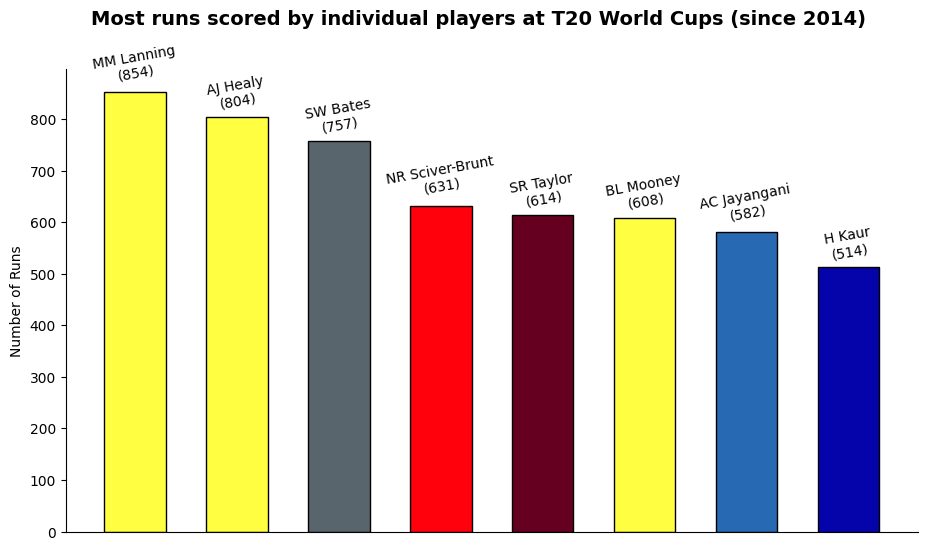

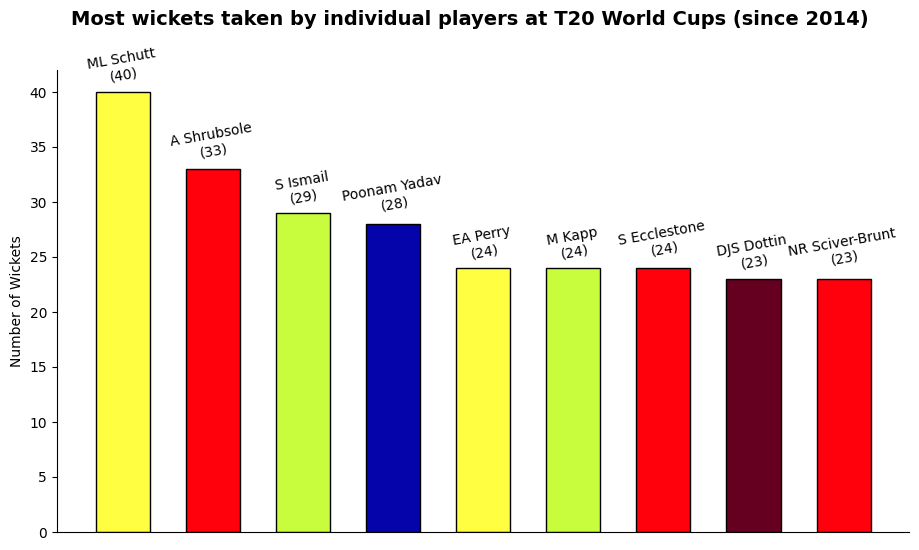

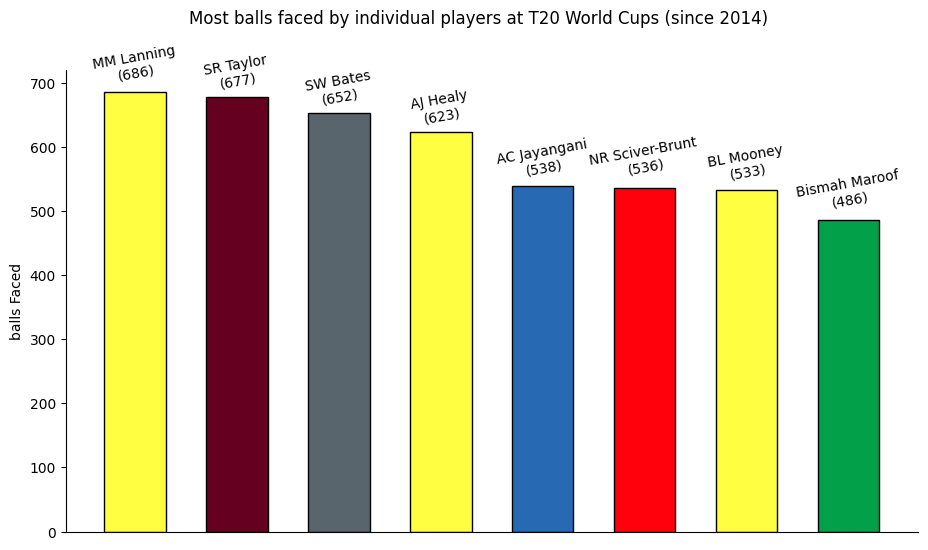

In [24]:

# most runs scored by individual players
fig2, ax2 = plt.subplots(figsize=(11, 6))
fig2.suptitle("Most runs scored by individual players at T20 World Cups (since 2014)",fontsize=14,fontweight='bold')
get_top_wicks_and_runs(ax2,'runs')

# most wickets taken by individual players
fig3, ax3 = plt.subplots(figsize=(11, 6))
fig3.suptitle("Most wickets taken by individual players at T20 World Cups (since 2014)",fontsize=14,fontweight='bold')
get_top_wicks_and_runs(ax3,'wickets')

# players who have faced the most balls 
balls_faced_by_batters = pd.DataFrame([[batter,batter_df.shape[0]] for batter,batter_df in top_run_wicket_data.groupby('batter')],columns=['player','balls faced'])
most_balls_faced = balls_faced_by_batters.nlargest(8,'balls faced',keep='all').set_index('player')

fig4, ax4 = plt.subplots(figsize=(11,6))
fig4.suptitle("Most balls faced by individual players at T20 World Cups (since 2014)")
make_bar_chart(ax4,most_balls_faced,"balls Faced",'balls faced')



remarks about those graphs 

ball pie chart intros 

In [25]:

def make_runs_pie_charts(column,colours,axis,df,title,alphabetical=True):   
    """Creates and deals with the formatting for the number of runs scored per ball"""
    counts =  df[column].value_counts().sort_index(ascending=alphabetical).tolist() 
    if len(counts) != 7:
        counts = counts[0:5] + [0] + [counts[5]]
    (for_legend,_,texts) = axis.pie(x=counts,colors=colours,autopct= lambda p : '{:.1f}%'.format(p) if p > 0 else '',
                             wedgeprops={'edgecolor' : 'black'},radius=1.1,pctdistance=0.65,startangle=340,textprops = {'color' : 'xkcd:pale blue'})
    axis.set_title(title)
    sets = [(0,0),(0,0),(0,-0.7),(0.5,-0.6),(0.1,-0.05),(0.7,-0.3),(0.7,-0.05)]
    for idx,text in enumerate(texts):
        try: 
            if float(text.get_text()[:-1]) < 20:
                (x,y) = text.get_position()
                text.set_position((x + sets[idx][0],y + sets[idx][1]))
            if idx == 2 or idx ==3:
                text.set_color('black')
                axis.annotate('', xy=(x+0.125,y-0.25), xytext=(0.9*(x + sets[idx][0]), 0.9*(y + sets[idx][1])),
                               arrowprops=dict(arrowstyle='-'))
            elif idx == 5 or idx == 6:
                text.set_color('black')
                axis.annotate('', xy=(x+0.3,y-0.15), xytext=(0.9*(x + sets[idx][0]) -0.1 , 0.9*(y + sets[idx][1])),
                               arrowprops=dict(arrowstyle='-'))

        except ValueError:
            pass
    return for_legend


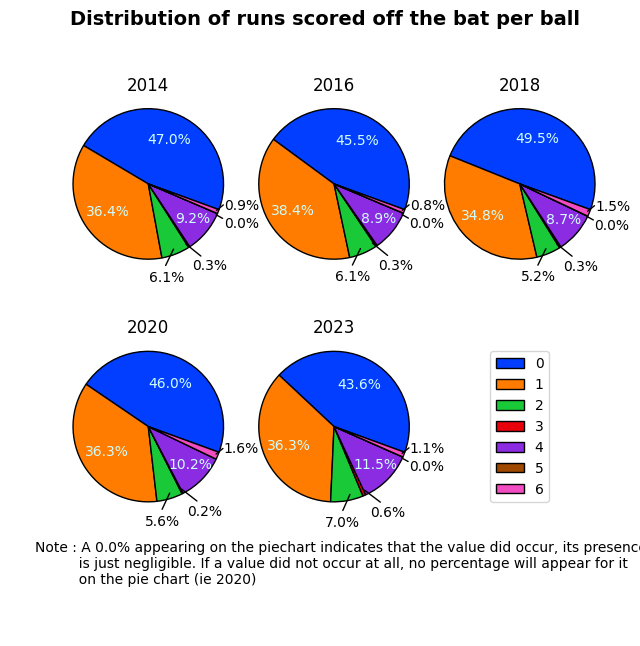

In [31]:
# 0/1/2/4/6s per tournament (pie chart) 
years = [x for _,x in top_run_wicket_data.groupby('season')]

fig5, ax5 = plt.subplots(2,3,figsize=(7,7))
ax5 = ax5.ravel()

for ax,year,title in zip(ax5,years,YEARS):
    legend_cols = make_runs_pie_charts('runs_off_bat',DEFAULT_COLOURS,ax,year,title)

ax5[-1].set_axis_off()
ax5[-1].legend(legend_cols,np.arange(0,7),loc='center',fontsize=10)
ax5[-1].annotate(f'Note : A 0.0% appearing on the piechart indicates that the value did occur, its presence \n          is just negligible. If a value did not occur at all, no percentage will appear for it \n          on the pie chart (ie 2020)',
                xy=(25,45),xycoords='figure points')
fig5.suptitle("Distribution of runs scored off the bat per ball",fontsize=14,fontweight='bold')
fig5.subplots_adjust(bottom=0.229,top=0.886,wspace=0.086,hspace=0.117)

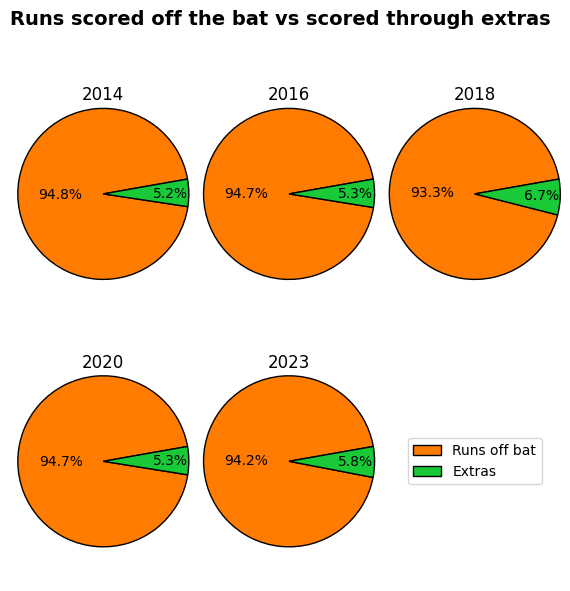

In [32]:
# runs scored off bat vs extras per tournament (pie charts)
extras_df = raw_data[['season','runs_off_bat','extras_off_ball']].copy()
years = [x for _,x in extras_df.groupby('season')]
fig7, axes7 = plt.subplots(2,3,figsize=(7,7))
ax7 = axes7.ravel()

for ax,year,title in zip(ax7,years,YEARS):
    counts = np.array([year['runs_off_bat'].sum(),year['extras_off_ball'].sum()])
    (for_legend,_,texts) = ax.pie(x=counts,colors=DEFAULT_COLOURS[1:3],autopct='%1.1f%%',radius=1.25,pctdistance=0.5,
           startangle=10,wedgeprops={'edgecolor' : 'black'},textprops={'fontsize' : 10})
    (x,y) = texts[1].get_position()
    texts[1].set_position((x+0.35,y))
    ax.set_title(title)
      

ax7[-1].set_axis_off()
ax7[-1].legend(for_legend,['Runs off bat','Extras'],loc='center',fontsize=10)
fig7.suptitle("Runs scored off the bat vs scored through extras",fontsize=14,fontweight='bold')
fig7.subplots_adjust(bottom=0.164,top=0.888,wspace=0.086,hspace=0.117)


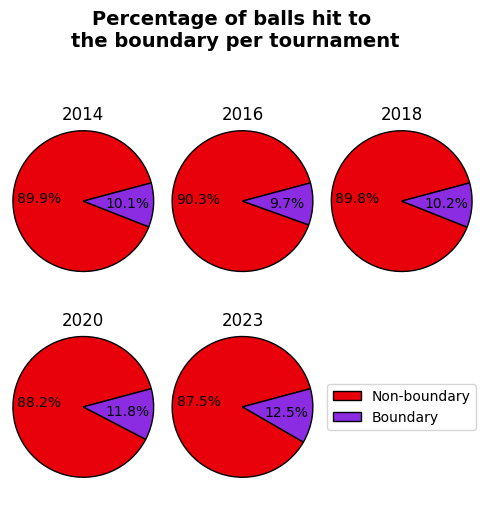

In [33]:
# percentage of balls which go for a boundary (bar chart ??)
boundary_balls_df = raw_data[['season','runs_off_bat','non_boundary']].copy()

fig8 , ax8 = plt.subplots(2,3,figsize=(6,6))
ax8 = ax8.ravel()
years = [x for _,x in boundary_balls_df.groupby('season')]

for ax,year,title in zip(ax8,years,YEARS):
    x = year['runs_off_bat'].value_counts()
    boundaries = x.loc[4] + x.loc[6] - year[~year['non_boundary'].isnull()].shape[0]
    counts = (x.sum() - boundaries, boundaries)
    (for_legend,_,_) = ax.pie(counts,colors=DEFAULT_COLOURS[3:5],autopct='%1.1f%%',radius=1.2,pctdistance=0.63,
            startangle=15,wedgeprops={'edgecolor' : 'black'},textprops={'fontsize' : 10})
    ax.set_title(title)
    
ax8[-1].set_axis_off()
ax8[-1].legend(for_legend,['Non-boundary','Boundary'],loc='center',fontsize=10)
fig8.suptitle("Percentage of balls hit to \nthe boundary per tournament",fontsize=14,fontweight='bold')
fig8.subplots_adjust(bottom=0.164,top=0.814,wspace=0.086,hspace=0.117)

comments about balls

intro for next graph

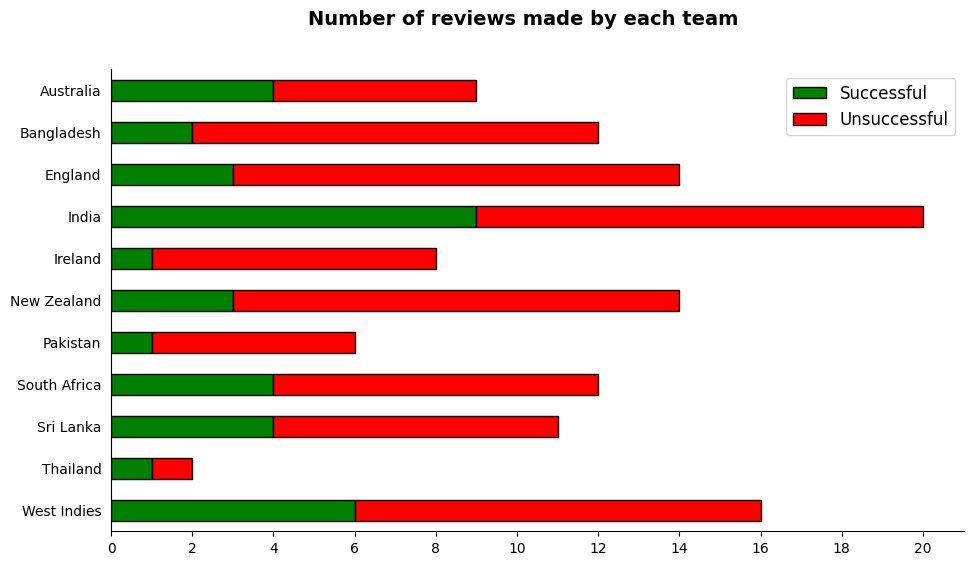

In [29]:
# success percentage of reviews per team (bar chart)
review_data = raw_data[['review_by','review_decision']].copy()
dfs = []

for team,df in review_data.groupby('review_by'):
    x = df.value_counts()
    dfs.append([team,x[team]['upheld'],x[team]['struck down']])

fig6, ax6 = plt.subplots(figsize=(11,6))
review_comp = pd.DataFrame(dfs,columns=['Team','Successful','Unsuccessful'])[::-1].set_index('Team')
review_comp.plot(kind='barh',stacked=True,ax=ax6,color=['green','red'],edgecolor='black')

fig6.suptitle("Number of reviews made by each team",fontsize=14,fontweight='bold')
ax6.legend(loc='upper right',fontsize = 12)
ax6.spines[['right', 'top']].set_visible(False)
ax6.set_xticks(np.arange(0,22,2))
ax6.tick_params(axis='y',width = 0)
ax6.set_ylabel('')
plt.show()

comments and intro for final graph

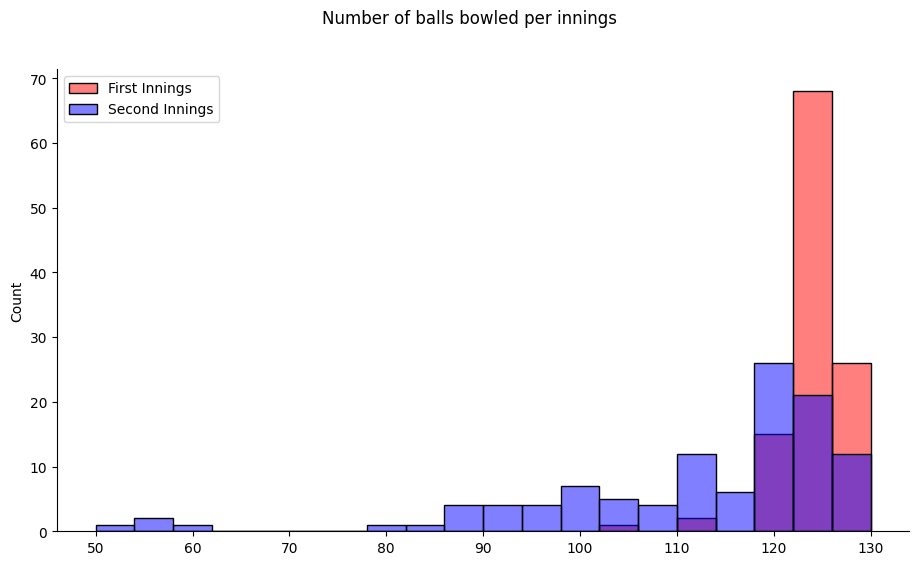

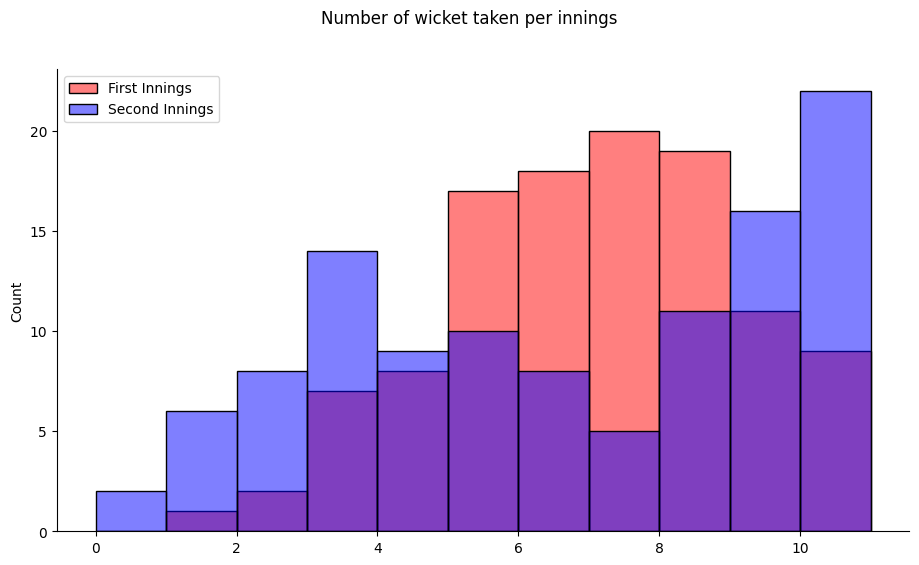

In [34]:
# number of balls per innings  (histogram) (could do first and second seperatly)
num_ball_df = raw_data[['season','RecNo','player_out']].copy()
num_ball_df['first innings'] = num_ball_df['RecNo'].str[2] == 'a'
num_balls = [[df.shape[0] for _,df in x.groupby('RecNo')] for _,x in num_ball_df.groupby('first innings')]

fig9 , ax9 = plt.subplots(figsize=(11, 6))
sns.histplot(num_balls,ax=ax9,binwidth=4,palette=['blue','red'])
ax9.spines[['right', 'top']].set_visible(False)
fig9.suptitle("Number of balls bowled per innings")
ax9.legend(loc='upper left',labels=['First Innings','Second Innings'])

# average wickets taken per innings per tournament
num_out = [[df['player_out'].count() for r,df in x.groupby('RecNo')] for _,x in num_ball_df.groupby('first innings')]
fig10 , ax10 = plt.subplots(figsize=(11, 6))
sns.histplot(num_out,ax=ax10,binwidth=1,palette=['blue','red'])
fig10.suptitle("Number of wicket taken per innings")
ax10.legend(labels=['First Innings','Second Innings'])
ax10.spines[['right', 'top']].set_visible(False)

Final comments + finish